In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
def gp_inference(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
    model.likelihood.variance.prior = tfp.distributions.LogNormal(loc=np.log(0.07), scale=0.5)
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def plot_noisy_3d(Y_noisy, mesh_size, cmap='viridis'):
    """
    Plots a 3D surface of the noisy sampled data on a 2D grid.

    Parameters:
    - Y_noisy: 1D or 2D array-like of noisy sampled data.
    - mesh_size: The size of one dimension of the square mesh grid.
    - cmap: Colormap for the surface plot (default 'viridis').
    """
    # Prepare the grid for plotting
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X, Y = np.meshgrid(x, y)

    # Reshape Y_noisy to a 2D grid if needed
    Z = np.array(Y_noisy).reshape(mesh_size, mesh_size)

    # Create a 3D figure and axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap)

    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Noisy Data Value')
    plt.title('Noisy Sampled Data in 3D')

    plt.show()
    
def plot_gp_with_subsamples(Y_full, mesh_size, subsample_idx, Y_subsampled, 
                            title='GP Surface with Subsampled Data', cmap='viridis'):
    """
    Plots a 3D GP surface with overlaid subsampled data points.

    Parameters:
    -----------
    Y_full : array-like
        The full set of GP predictions or true values on a grid as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    subsample_idx : array-like
        Indices of the subsampled points within the grid (flattened index).
    Y_subsampled : array-like
        Values corresponding to the subsampled data points.
    title : str, optional
        Title for the plot. Default is 'GP Surface with Subsampled Data'.
    cmap : str, optional
        Colormap for the surface. Default is 'viridis'.

    Returns:
    --------
    None
        Displays a 3D plot.
    """
    # Convert inputs to numpy arrays
    Y_full = np.array(Y_full)
    subsample_idx = np.array(subsample_idx)
    Y_subsampled = np.array(Y_subsampled)

    # Verify that Y_full length matches mesh_size^2
    if Y_full.size != mesh_size**2:
        raise ValueError("Length of Y_full does not match mesh_size squared.")

    # Create the grid for the full surface
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)
    
    # Reshape the full surface data
    Z_full = Y_full.reshape(mesh_size, mesh_size)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the full GP surface
    surf = ax.plot_surface(X_grid, Y_grid, Z_full, cmap=cmap, edgecolor='none', alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Value')

    # Compute the grid coordinates for subsampled points
    subsampled_y = subsample_idx // mesh_size
    subsampled_x = subsample_idx % mesh_size
    subsampled_z = Y_subsampled.flatten()

    # Overlay the subsampled data points as red scatter points
    ax.scatter(subsampled_x, subsampled_y, subsampled_z, color='r', s=50, label='Subsampled Data')

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.legend()

    # Optionally adjust the viewing angle
    ax.view_init(elev=30, azim=225)  # Modify as needed

    plt.show()

def plot_error_field(Y_true, Y_pred, mesh_size, observation_positions=None, title='Error Field', cmap='coolwarm'):
    """
    Plots the error field between true and predicted values on a 2D grid.

    Parameters:
    -----------
    Y_true : array-like
        The true values on a grid as a 1D array of length mesh_size**2.
    Y_pred : array-like
        The predicted values on a grid as a 1D array of length mesh_size**2.
    mesh_size : int
        The size of one dimension of the mesh grid (assuming a square grid).
    observation_positions : array-like, optional
        Indices of the observed points within the grid (flattened index).
    title : str, optional
        Title for the plot. Default is 'Error Field'.
    cmap : str, optional
        Colormap for the error field. Default is 'coolwarm'.

    Returns:
    --------
    None
        Displays a 2D contour plot.
    """

    # Convert inputs to numpy arrays
    Y_true = np.array(Y_true).reshape(-1)
    Y_pred = np.array(Y_pred).reshape(-1)

    # Verify that Y_true and Y_pred lengths match mesh_size^2
    if Y_true.size != mesh_size**2 or Y_pred.size != mesh_size**2:
        raise ValueError("Length of Y_true or Y_pred does not match mesh_size squared.")

    # Compute the error field
    error_field = np.abs(Y_true - Y_pred)

    # Create the grid for the error field
    x = np.linspace(0, mesh_size - 1, mesh_size)
    y = np.linspace(0, mesh_size - 1, mesh_size)
    X_grid, Y_grid = np.meshgrid(x, y)

    # Reshape the error field
    Z_error = error_field.reshape(mesh_size, mesh_size)

    # Create a 2D contour plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the contour
    contour = ax.contourf(X_grid, Y_grid, Z_error, levels=25, cmap=cmap)
    cbar = fig.colorbar(contour, ax=ax, label='Error')

    # Overlay the observation positions as black scatter points
    if observation_positions is not None:
        obs_y = observation_positions // mesh_size
        obs_x = observation_positions % mesh_size
        ax.scatter(obs_x, obs_y, color='k', s=50, label='Observed Data', marker='x')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    if observation_positions is not None:
        ax.legend()

    # Show the plot
    plt.show()


In [5]:
# Parameters
mesh_size = 20
num_nodes = mesh_size**2
graph_type = '2D_mesh' # 'line', 'random', '2D_mesh'

In [6]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix
elif graph_type == '2D_mesh':
    adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()
    

In [7]:
# G = nx.from_numpy_array(adjacency_matrix)
# nx.draw(G)

In [8]:
beta_sample = 5
noise_std = 0.1

In [9]:
K_true = diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=0, seed=0)
Y_noisy = generate_noisy_samples(K_true,noise_std=noise_std, seed=0)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))  # Input features (nodes)

# Randomly ubsample the data
subsample_factor = 4
subsample_idx = np.random.choice(num_nodes, num_nodes//subsample_factor, replace=False)

X_subsampled = X.numpy()[subsample_idx]
Y_noisy_subsampled = Y_noisy[subsample_idx]

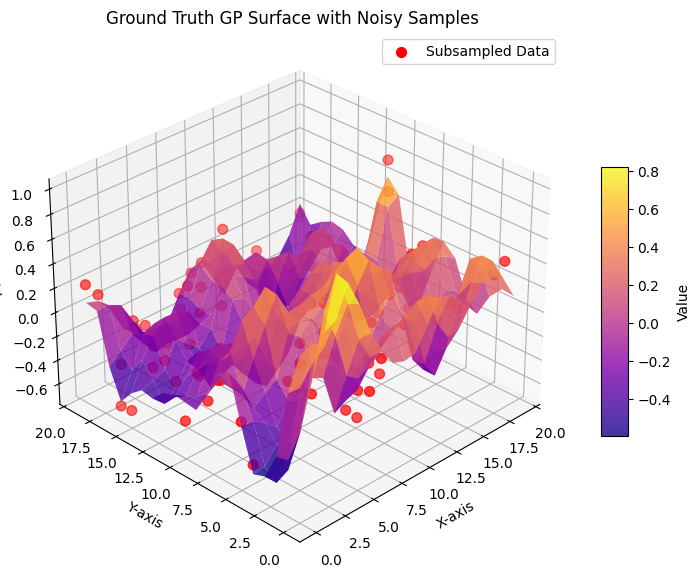

In [10]:
# Plot the GP surface with overlaid subsampled data
plot_gp_with_subsamples(Y, mesh_size, subsample_idx, Y_noisy_subsampled,
                        title='Ground Truth GP Surface with Noisy Samples', cmap='plasma')

In [11]:
WALKS_PER_NODE = 100
P_HALT = 0.1
MAX_WALK_LENGTH = 5

In [12]:
X_train = tf.convert_to_tensor(X_subsampled)
Y_train = tf.convert_to_tensor(Y_noisy_subsampled.reshape(-1, 1))
X_full = X

# note the modulator vector is randomly initialized
graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                         walks_per_node=WALKS_PER_NODE,
                                         p_halt=P_HALT,
                                         max_walk_length=MAX_WALK_LENGTH)

model, mean, stddev = gp_inference(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

╒═════════════════════════════╤═══════════╤══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═════════════════════════════════════════╕
│ name                        │ class     │ transform        │ prior     │ trainable   │ shape   │ dtype   │ value                                   │
╞═════════════════════════════╪═══════════╪══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═════════════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │           │ True        │ (5,)    │ float64 │ [0.46449785, -0.31530235, 0.00976993... │
├─────────────────────────────┼───────────┼──────────────────┼───────────┼─────────────┼─────────┼─────────┼─────────────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │ LogNormal │ True        │ ()      │ float64 │ 0.026770626259632595                    │
╘═════════════════════════════╧═══════════╧══════════════════╧═══════════╧═════════════╧══════

In [13]:
print(model.kernel.modulator_vector.numpy())

[ 0.46449785 -0.31530235  0.00976993 -0.00398998 -0.0047917 ]


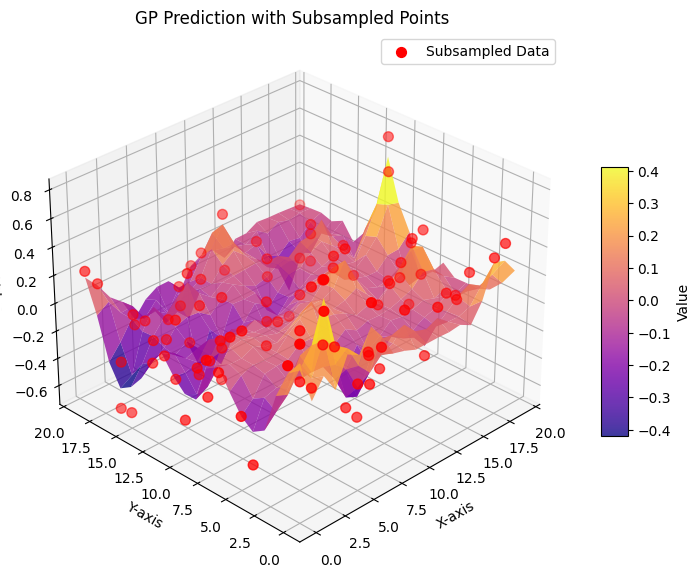

In [14]:
plot_gp_with_subsamples(mean.numpy(), mesh_size, subsample_idx, Y_noisy_subsampled,
                        title='GP Prediction with Subsampled Points', cmap='plasma')

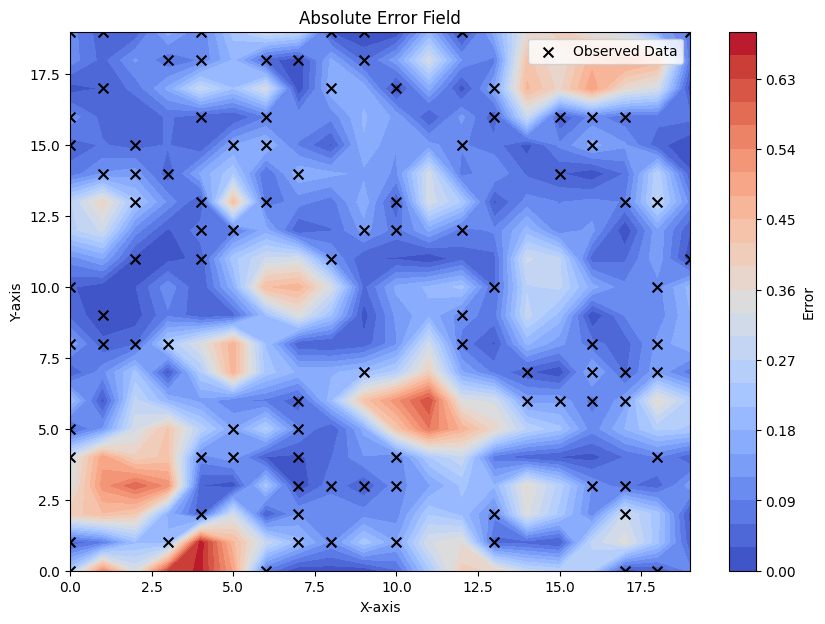

In [16]:
# Plot the Error Field

plot_error_field(Y, mean.numpy().flatten(), mesh_size, observation_positions=subsample_idx, title='Absolute Error Field', cmap='coolwarm')

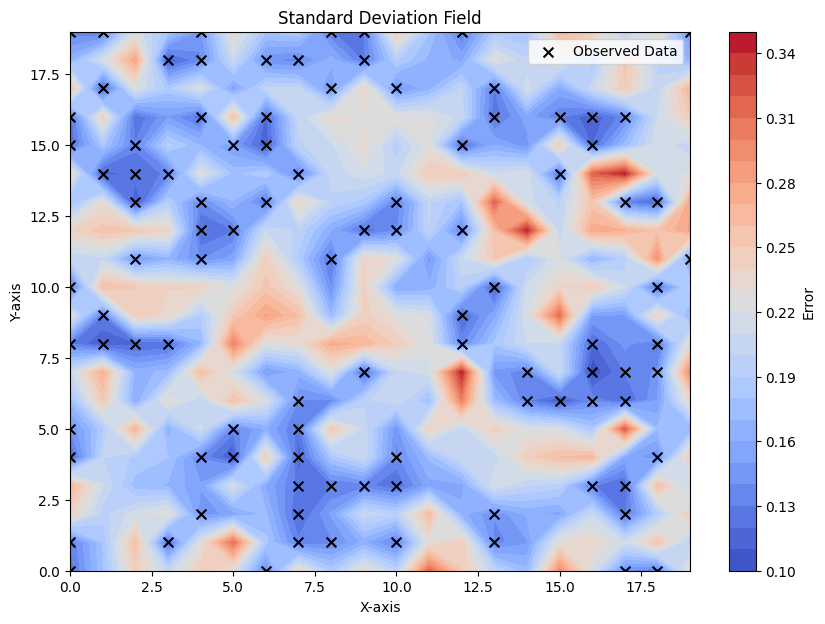

In [17]:
plot_error_field(stddev.numpy().flatten(), np.zeros_like(stddev.numpy().flatten()), mesh_size, observation_positions=subsample_idx, title='Standard Deviation Field', cmap='coolwarm')

In [18]:
# calculate the MSE

test_idx = np.setdiff1d(np.arange(num_nodes), subsample_idx)

Y_test = Y[test_idx]
mean_test = mean.numpy()[test_idx]

mse = np.mean((Y_test - mean_test.flatten())**2)
print(f"MSE: {mse:.4f}")


MSE: 0.0987
